# Multi-Label Image Classification with CheXpert and MIMIC-CXR

I set uncertainty u = 1 for the first trials while I figured out issues.

The CheXpert paper uses an Adam optimizer withh default beta and constant learning rate = 1e-4, uses batch norm with 16 img-sized batches, 3 epochs, and saves checkpoint every 4800 iterations. They used the DenseNet121 architecture.

The original DenseNet paper used Nesterov momentum without dampening, SGD, also learning rate decay and weight decay. They use Batch normalization and dropout = 0.2.  With their ImageNet model they used mini-batch gradient descent with no dropout.

Of the papers which didn't use Adam, or which used it the right way when combined with weight decay, many failed to realize that, when used together with batch norm, weight decay and learning rate decay are no more independent. This is fully explained in "Decoupled Weight Decay Regularization". I will start with their AdamWR algorithm, which has a corrected weight decay with a normalized batch norm, and uses cosine annealing to attempt to improve the speed of convergence.

In [35]:
import copy
import os
import time
from pathlib import Path
import timeit

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import zarr
from PIL import Image
from torch.utils.data import Dataset, TensorDataset, WeightedRandomSampler
from torch.utils.data.dataloader import DataLoader
from torchvision import models, transforms, utils

import src.models.efficient_densenet_pytorch.models.densenet as dnet2  # Alternative efficient densenet to test
from src.models import adamw, compare_auc_delong_xu, densenet, cosine_scheduler

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.0.1.post2
Torchvision Version:  0.2.1


In [2]:
# Top level data directory (can be 'CheXpert-v1.0-small', 'CheXpert-v1.0', 'mimic-cxr')
root_dir = 'data'
which_data = 'CheXpert-v1.0'
raw_data_dir = f'{root_dir}/raw/{which_data}'
int_data_dir = f'{root_dir}/interim'
proc_data_dir = f'{root_dir}/processed'

# Data is split into two sets (may later create a training-dev set)
phases = ['train', 'val']

# Path to csvfiles on training and validation data
csvpath = {phase: f'{raw_data_dir}/{phase}.csv' for phase in phases}

# Load data into dictionary of two Pandas DataFrames
dframe = {phase: pd.read_csv(csvpath[phase]) for phase in phases}

# Calculate sizes
dataset_sizes = {phase: len(dframe[phase]) for phase in phases}

print(os.listdir(raw_data_dir))
print(dframe['train'].shape, dframe['val'].shape)

['train', 'train.csv', 'val.csv', 'CheXpert-v1.0.zip', 'valid']
(223414, 19) (234, 19)


In [34]:
dframe['train'].sample(1)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
166283,CheXpert-v1.0/train/patient38778/study5/view2_...,Male,73,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN


In [33]:
dframe['val'].sample(1)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
112,CheXpert-v1.0/valid/patient64623/study1/view1_...,Male,74,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


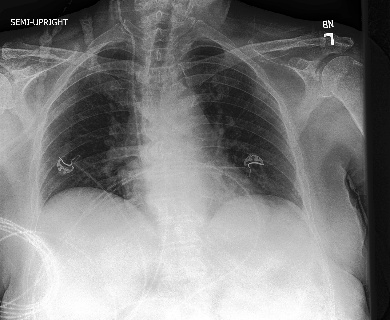

In [3]:
Image.open('data/raw/CheXpert-v1.0-small/valid/patient64574/study1/view1_frontal.jpg')

In [4]:
# Models to choose from [efficient-densenet, resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "efficient-densenet"

# Number of classes in the dataset
num_classes = 14

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 5

# Number of minibatches to pass before printing out metrics
checkpoint = 200

# Flag for feature extracting. When False, we finetune the whole model, when True we only update the reshaped layer params
feature_extract = False

# The number of training samples
num_samples = dframe['train'].shape[0]

# Class names that will be predicted
class_names = dframe['train'].iloc[:, 5:].columns

# indices we will calculate AUC for, as in the CheXpert paper
competition_tasks = torch.ByteTensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

# Which approach to use when dealing with uncertain labels (as detailed in the CheXpert paper)
u_approach = 'ones'

# Using pretrained weights
use_pretrained = True

# filename for outputs
filename = f'{which_data}_{model_name}_{u_approach}_{batch_size}'

# Calculating weighting for imbalanced classes (input in loss criterion)
df = dframe['train'].iloc[:, 5:].copy()
df = df.replace(-1, 0)
pos_weight = torch.Tensor([df[cl].sum() / df.shape[0] for cl in class_names])

In [5]:
# Use CUDA for PyTorch
# use_cuda = 0
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print('Using CUDA') if use_cuda else print('Using CPU')

print(torch.cuda.memory_cached() / 1e9)
print(torch.cuda.max_memory_cached() / 1e9)
print(torch.cuda.memory_allocated() / 1e9)
print(torch.cuda.max_memory_allocated() / 1e9)

Using CUDA
0.0
0.0
0.0
0.0


In [8]:
class CheXpertDataset(Dataset):
    """CheXpert dataset."""

    def __init__(self, phase, u_approach, num_samples, datapath):
        """
        Args:
            phase (str): val or train
            u_approach (str): Deter
            tforms (Torch Transform): pre-processing transforms
            targets (DataFrame): Modifies labels depending on u_approach
        """
        self.phase = phase
        self.u_approach = u_approach
        self.num_samples = num_samples
        self.datapath = datapath
        #         self.data = zarr.open_group(self.datapath,mode='r')
        #         self.data = h5py.File(f'{self.datapath}', 'r',libver='latest', swmr=True)
        self.data = None

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if not self.data:  # open in thread
            self.data = h5py.File(f'{self.datapath}', 'r')
        img = np.float32(self.data[f"X{idx}"][()])

        labels = np.float32(self.data[f"y{idx}"][()])

        return img, labels

In [7]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
            

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    if model_name == "resnet":
        """ Resnet18
        Not very heavy on the gpu
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        Used in the CheXpert paper
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "efficient-densenet":
        """memory-efficient densenet - https://github.com/wandering007/efficient-densenet-pytorch
        10-20% change in memory usage, about the same speed as original DenseNet
        """
        # # 
        growth_rate = 32  # (int) - how many filters to add each layer (`k` in paper)
        block_config = (6, 12, 24, 16)  # (list of 3 or 4 ints) - how many layers in each pooling block
        compression = 0.5  # Reduction in size
        num_init_features = 2 * growth_rate  # (int) - the number of filters to learn in the first convolution layer
        bn_size = 4  # (int) - mult. factor for number of bottle neck layers (i.e. bn_size * k features in the bottleneck layer)
        drop_rate = 0.  # (float) - dropout rate after each dense layer
        efficient = True  # (bool) - set to True to use checkpointing. Much more memory efficient, but slower.
        input_size = 224

        model_ft = densenet.DenseNet(num_init_features=num_init_features, block_config=block_config,
                                     compression=compression,
                                     input_size=input_size, bn_size=bn_size, drop_rate=drop_rate, num_classes=1000,
                                     efficient=efficient)
        if use_pretrained:
            partial_state_dict = torch.load('src/models/densenet121_effi.pth')
            state_dict = model_ft.state_dict()
            state_dict.update(partial_state_dict)
            model_ft.load_state_dict(state_dict, strict=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == "efficient-densenet-v2":
        """memory-efficient densenet, alternative version - https://github.com/gpleiss/efficient_densenet_pytorch
        Can load batches more than twice as large as original DenseNet, at less than half the speed
        """
        # # 
        growth_rate = 32  # (int) - how many filters to add each layer (`k` in paper)
        block_config = (6, 12, 24, 16)  # (list of 3 or 4 ints) - how many layers in each pooling block
        compression = 0.5  # Reduction in size
        num_init_features = 2 * growth_rate  # (int) - the number of filters to learn in the first convolution layer
        bn_size = 4  # (int) - mult. factor for number of bottle neck layers (i.e. bn_size * k features in the bottleneck layer)
        drop_rate = 0.  # (float) - dropout rate after each dense layer
        efficient = True  # (bool) - set to True to use checkpointing. Much more memory efficient, but slower.
        input_size = 224

        # model_ft = densenet.DenseNet(num_init_features=num_init_features, block_config=block_config, compression=compression,
        #          input_size=input_size, bn_size=bn_size, drop_rate=drop_rate, num_classes=1000, efficient=efficient)

        model_ft = dnet2.DenseNet(growth_rate=32, block_config=block_config, compression=0.5,
                                  num_init_features=num_init_features, bn_size=4,
                                  drop_rate=0, num_classes=1000, small_inputs=False, efficient=True)

        if use_pretrained:
            state_dict = model_ft.state_dict()
            partial_state_dict = torch.load('src/models/densenet121_effi.pth')
            partial_state_dict = {k: v for k, v in partial_state_dict.items() if k in state_dict}
            state_dict.update(partial_state_dict)
            model_ft.load_state_dict(state_dict, strict=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [6]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, competition_tasks,
                num_epochs=25, u_approach=None, is_inception=False, checkpoint=200):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0.0
    missing = 0
    fsize = dataset_sizes['train'] / (checkpoint * batch_size)  # Number of saved values for training metrics/epoch
    num_items = int(
        np.ceil((fsize + num_epochs) * num_epochs))  # Total number of items including saved validation values
    idx = 0  # index for adding to DataFrame
    columns = ['epoch', 'iteration', 'loss', 'accuracy', 'variance']
    # Save training values every "checkpoint" batches, save num_epoch validation values:
    df = pd.DataFrame(np.zeros([num_items, len(columns)]), columns=columns)
    df['phase'] = ''

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_auc = 0.0
            running_var = 0.0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    if u_approach == "ignore":
                        mask = labels.lt(0)  # select u labels (-1)
                        loss = torch.sum(loss.masked_select(mask))  # mask out uncertain labels
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.batch_step() #use with AdamWR and cosine annealing

                # statistics
                running_loss += loss.item() * inputs.size(0)

                # select subset of 5 pathologies of interest
                labels_sub = labels[:, competition_tasks].cpu().squeeze().numpy()
                preds_sub = outputs[:, competition_tasks].detach().cpu().squeeze().numpy()

                if u_approach == "ignore":
                    # mask out the negative values
                    mask_sub = (labels_sub > -1)
                    for j in range(labels_sub.shape[1]):
                        label = labels_sub[:, j]
                        pred = preds_sub[:, j]
                        m = mask_sub[:, j]
                        label = label[m]
                        pred = pred[m]
                        try:
                            tmp = compare_auc_delong_xu.delong_roc_variance(label, pred)
                            running_auc += tmp[0]
                            running_var += np.nansum(tmp[1])
                        except AssertionError:
                            missing += 1
                            continue
                else:
                    for j in range(labels_sub.shape[1]):
                        label = labels_sub[:, j]
                        pred = preds_sub[:, j]
                        tmp = compare_auc_delong_xu.delong_roc_variance(label, pred)
                        running_auc += tmp[0]
                        running_var += np.nansum(tmp[1])

                if (i + 1) % checkpoint == 0:  # print every 'checkpoint' mini-batches
                    #                     print('Missed {}'.format(missing))
                    print(f'{phase} Loss: {(running_loss / ((i + 1) * batch_size)):.2f} DeLong AUC: '
                          f'{running_auc / (labels_sub.shape[1] * (i + 1) * batch_size):.2f}')

                df.iloc[idx, :] = [epoch + 1,
                                   (i + 1) * (epoch + 1),
                                   running_loss / ((i + 1) * batch_size),
                                   running_auc / (labels_sub.shape[1] * (i + 1) * batch_size),
                                   running_var / (labels_sub.shape[1] * (i + 1) * batch_size),
                                   phase]
                idx += 1
        #                     break #just while testing

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_auc = running_auc / (dataset_sizes[phase] * labels_sub.shape[1])
        epoch_var = running_var / (dataset_sizes[phase] * labels_sub.shape[1])
        print(f'{phase} Epoch Loss: {epoch_loss:.2f} Epoch AUC: {epoch_auc:.2f} Epoch Variance: {epoch_var:.2f}')
        # With a small validation set would otherwise get no recorded values so:
        if phase == 'val':
            df.iloc[idx, :] = [epoch + 1, 0, epoch_loss, epoch_auc, epoch_var, phase]
            idx += 1

        # deep copy the model
        if phase == 'val' and epoch_auc > best_auc:
            best_auc = epoch_auc
            best_model_wts = copy.deepcopy(model.state_dict()) #Should also copy optimizer dict

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.2f}m {time_elapsed % 60:.2f}s')
    print(f'Best val AUC: {best_auc:.2f}')
    print(f'Missed {missing} examples.')
    # load best model weights
    model.load_state_dict(best_model_wts)

    df.to_csv(f'models/{filename}.csv', index=False)
    return model

In [9]:
# Initialize
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

# preprocess target labels before placing in dataloader
labels_array = {phase: dframe[phase].iloc[:, 5:].copy().fillna(0) for phase in phases}

for phase in labels_array.keys():
    if u_approach == 'ones':
        labels_array[phase] = labels_array[phase].replace(-1, 1)
    elif u_approach == 'zeros':
        labels_array[phase] = labels_array[phase].replace(-1, 0)
    labels_array[phase] = torch.FloatTensor(labels_array[phase].to_numpy())  # needed when using cross-entropy loss

# Transforms to perform on images (already performed for hdf5 files)
tforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])}
hdf5paths = {phase: f'{int_data_dir}/{phase}_u{u_approach}_inp{input_size}_processed.h5' for phase in phases}
zarrpaths = {phase: f'{proc_data_dir}/{phase}_u{u_approach}_inp{input_size}_processed.zarr' for phase in phases}
# Create the datasets
# datasets = {phase: CheXpertDataset(phase=phase, u_approach=u_approach, num_samples=dataset_sizes[phase],
# datapath=zarrpaths[phase]) for phase in phases}
datasets = {
    phase: CheXpertDataset(phase=phase, u_approach=u_approach, num_samples=dataset_sizes[phase],
                           datapath=hdf5paths[phase])
    for phase in phases}

In [10]:
def proc_images(img_paths, labels_array, data_dir, u_approach, input_size, phases=None, tforms=None):
    """
    Saves compressed, resized images as HDF5 datsets
    Returns
        data.h5, where each dataset is an image or class label
        e.g. X23,y23 = image and corresponding class labels
    """
    if phases is None:
        phases = ['train', 'val']
    for phase in phases:
        print(f'Processing {phase} files...')
        with h5py.File(f'{data_dir}/{phase}_u{u_approach}_inp{input_size}_processed.h5', 'w') as hf:
            for i, img_path in enumerate(img_paths[phase]):
                if i % 2000 == 0:
                    print(f"{i} images processed")

                # Images
                # Using Pillow-SIMD rather than Pillow
                img = Image.open(img_path).convert('RGB')
                if tforms:
                    img = tforms[phase](img)
                hf.create_dataset(
                    name=f"X{i}",
                    data=img,
                    shape=(3, input_size, input_size),
                    maxshape=(3, input_size, input_size),
                    compression="lzf",
                    shuffle="True")
                # Labels
                hf.create_dataset(
                    name=f"y{i}",
                    data=labels_array[phase][i, :],
                    shape=(num_classes,),
                    maxshape=(num_classes,),
                    compression="lzf",
                    shuffle="True",
                    dtype="i1")
    print('Finished!')


hdf50 = Path(f'{int_data_dir}/{phases[0]}_u{u_approach}_inp{input_size}_processed.h5')
hdf51 = Path(f'{int_data_dir}/{phases[1]}_u{u_approach}_inp{input_size}_processed.h5')
zarr0 = Path(f'{proc_data_dir}/{phases[0]}_u{u_approach}_inp{input_size}_processed.zarr')
zarr1 = Path(f'{proc_data_dir}/{phases[1]}_u{u_approach}_inp{input_size}_processed.zarr')

if not (hdf50.is_file() or hdf51.is_file()):
    img_paths = {phase: raw_data_dir + dframe[phase].iloc[:, 0] for phase in phases}
    proc_images(img_paths, labels_array, data_dir, u_approach, input_size, phases=phases, tforms=tforms)

if not (zarr0.is_dir() or zarr1.is_dir()):
    source = h5py.File(hdf5paths['val'], mode='r')
    dest = zarr.open_group(zarrpaths['val'], mode='w')
    zarr.copy_all(source, dest, log="zarr1.output")

    source = h5py.File(hdf5paths['train'], mode='r')
    dest = zarr.open_group(zarrpaths['train'], mode='w')
    zarr.copy_all(source, dest, log="zarr0.output")

In [21]:
# Accounting for imbalanced classes
df = dframe['train'].iloc[:,5:].fillna(0).copy()
# df = df.replace(-1, np.nan)

# Get a list of the number of positive, negative, and uncertain samples for each class
class_sample_count = [df[df==t].count() for t in [-1, 0, 1]]
print(class_sample_count)

# Use this to calculate the frequencies for positive, negative, and uncertain samples for each class
reciprocal_weights = [num_classes * class_sample_count[t] * (1 / num_samples) for t in range(len(class_sample_count))]

# Create list of weights as long as the dataset
reciprocal_sample_weights = reciprocal_weights[0] * (df==-1) + reciprocal_weights[1] * (df==0) + reciprocal_weights[2] * (df==1)
sample_weights = 1 / reciprocal_sample_weights.to_numpy()

# Load into sampler
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

[No Finding                        0
Enlarged Cardiomediastinum    12403
Cardiomegaly                   8087
Lung Opacity                   5598
Lung Lesion                    1488
Edema                         12984
Consolidation                 27742
Pneumonia                     18770
Atelectasis                   33739
Pneumothorax                   3145
Pleural Effusion              11628
Pleural Other                  2653
Fracture                        642
Support Devices                1079
dtype: int64, No Finding                    201033
Enlarged Cardiomediastinum    200213
Cardiomegaly                  188327
Lung Opacity                  112235
Lung Lesion                   212740
Edema                         158184
Consolidation                 180889
Pneumonia                     198605
Atelectasis                   156299
Pneumothorax                  200821
Pleural Effusion              125599
Pleural Other                 217238
Fracture                      213732


In [12]:
# Setting parameters
# num_workers = torch.get_num_threads()
num_workers = 1  # Use with hdf5 files
params = {'train': {'batch_size': batch_size,
                    'shuffle': True,
                    'num_workers': num_workers,
                    'pin_memory': True,
                    'sampler': None},
          'val': {'batch_size': batch_size,
                  'shuffle': False,
                  'num_workers': num_workers,
                  'pin_memory': True}}
if params['train']['sampler'] is not None:
    params['train']['shuffle'] = False

dataloaders = {phase: DataLoader(datasets[phase], **params[phase]) for phase in phases}


0 (3, 224, 224) (14,)
1 (3, 224, 224) (14,)
2 (3, 224, 224) (14,)
3 (3, 224, 224) (14,)


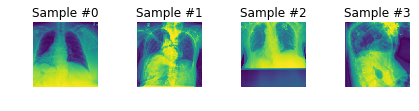

In [13]:
# Show transformed images
fig = plt.figure()

for i in range(len(datasets['train'])):
    sample = datasets['train'][i]
    print(i, sample[0].shape, sample[1].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0][0, :, :])

    if i == 3:
        plt.show()
        break

In [14]:
# Checking for shuffling (when using Weighted Sampler)
for i, (inputs, labels) in enumerate(dataloaders['val']):
    if i < 1:
        print(labels.size(0))
        labels[labels == -1] = 0
        print(torch.sum(labels, dim=0))
        labels = labels[:, competition_tasks]
        print(labels.shape)
        #     else:
        break

64
tensor([18., 18., 12., 27.,  0.,  7.,  7.,  4., 16.,  3.,  8.,  0.,  0., 20.])
torch.Size([64, 5])


In [15]:
# Checking times for various image processing libraries
times = []
t0 = time.time()
for i, (inputs, labels) in enumerate(dataloaders['train']):
    if i < 1:
        times.append(time.time() - t0)
        t0 = time.time()
        break
print(f'Average time to load up data: {np.round(np.mean(times), 4)} s')
# With batch size of 64, num_cores = 1
# 2.8-3 s for zarr dataset
# 3.6-4 s for hdf5 datasets
# 5.3-6 s for original method with Pillow-SIMD
# 5.5-6.4 s for alternative PIL method
# 5.7-6.1 s for cv2

Average time to load up data: 2.0121 s


In [16]:
# Comparing zarr and hdf5 more precisely, with 1 core
setup = '''
import h5py
import zarr
zarr = zarr.open_group('data/processed/train_uones_inp224_processed.zarr','r')
'''

stmt1 = ''' 
with h5py.File('data/interim/train_uones_inp224_processed.h5','r') as h5:
    h5["X1"][:]
'''
stmt2 = ''' 
zarr["X1"][:]
'''

# timeit statement
print('hdf5:')
print(timeit.timeit(setup=setup, stmt=stmt1, number=10000))
print('zarr:')
print(timeit.timeit(setup=setup, stmt=stmt2, number=10000))

hdf5:
20.876329610822722
zarr:
56.427479394944385


0 torch.Size([64, 3, 224, 224]) torch.Size([64, 14])
1 torch.Size([64, 3, 224, 224]) torch.Size([64, 14])
2 torch.Size([64, 3, 224, 224]) torch.Size([64, 14])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([64, 3, 224, 224]) torch.Size([64, 14])


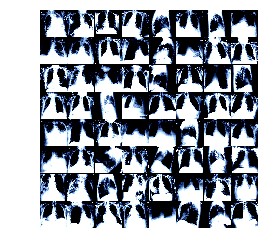

In [17]:
# Helper function to show a batch
def show_img_batch(sample_batched):
    """Show image with labels for a batch of samples."""
    images_batch, labels_batch = \
        sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


for i_batch, sample_batched in enumerate(dataloaders['train']):
    print(i_batch, sample_batched[0].size(), sample_batched[1].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_img_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [27]:
try:
    model_ft.load_state_dict(torch.load(f'models/{filename}.pt'))  # load weights if already completed
    print('Loading weights')
except FileNotFoundError:
    print('Starting from scratch..')

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_ft = nn.DataParallel(model_ft, device_ids=[0, 1])

model_ft = model_ft.to(device)

if u_approach == 'ignore':  # Use masked binary cross-entropy for first run
    criterion = nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight).to(device)
else:
    criterion = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight).to(device)

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# # Pick AdamW optimizer - https://github.com/mpyrozhok/adamwr
optimizer = adamw.AdamW(model_ft.parameters(), lr=1e-3, weight_decay=1e-5)
# Decay LR by a factor of 0.1 every 7 epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

epoch_size = int(num_samples / batch_size)  # number of training examples/batch size
# #Cosine annealing: adjusting on batch update rather than epoch - https://github.com/mpyrozhok/adamwr
scheduler = cosine_scheduler.CosineLRWithRestarts(optimizer, batch_size, epoch_size, restart_period=5, t_mult=1.2)

Loading weights
Let's use 2 GPUs!


In [32]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer, scheduler, competition_tasks,
                       num_epochs=num_epochs, u_approach=u_approach, is_inception=(model_name == "inception"),
                       checkpoint=checkpoint)

if torch.cuda.device_count() > 1:
    torch.save(model_ft.module.state_dict(), f'models/{filename}.pt')
else:
    torch.save(model_ft.state_dict(), f'models/{filename}.pt')

Epoch 0/4
----------
train Loss: 20605.09 DeLong AUC: 0.01 Variance: 0.00
train Epoch Loss: 0.46 Epoch AUC: 0.00 Epoch Variance: 0.00
val Epoch Loss: 216.55 Epoch AUC: 0.01 Epoch Variance: 0.00
Epoch 1/4
----------
train Loss: 9425.87 DeLong AUC: 0.01 Variance: 0.00
train Epoch Loss: 0.21 Epoch AUC: 0.00 Epoch Variance: 0.00
val Epoch Loss: 142.31 Epoch AUC: 0.01 Epoch Variance: 0.00
Epoch 2/4
----------
train Loss: 8228.63 DeLong AUC: 0.01 Variance: 0.00
train Epoch Loss: 0.18 Epoch AUC: 0.00 Epoch Variance: 0.00
val Epoch Loss: 136.59 Epoch AUC: 0.01 Epoch Variance: 0.00
Epoch 3/4
----------
train Loss: 8270.92 DeLong AUC: 0.01 Variance: 0.00
train Epoch Loss: 0.19 Epoch AUC: 0.00 Epoch Variance: 0.00
val Epoch Loss: 124.84 Epoch AUC: 0.01 Epoch Variance: 0.00
Epoch 4/4
----------
train Loss: 8110.75 DeLong AUC: 0.01 Variance: 0.00
train Epoch Loss: 0.18 Epoch AUC: 0.00 Epoch Variance: 0.00
val Epoch Loss: 118.44 Epoch AUC: 0.01 Epoch Variance: 0.00
Training complete in 1.00m 19.28s


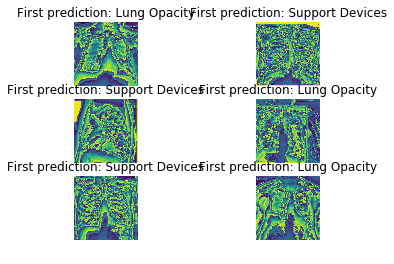

In [18]:
# Visualizing model predictions
def visualize_model(model, num_images=6):
    tform = transforms.Compose([transforms.functional.to_pil_image,
                                transforms.functional.to_grayscale])
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                img = tform(inputs[j].cpu())
                ax.set_title('First prediction: {}'.format(class_names[preds[j]]))
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_ft.load_state_dict(torch.load(f'models/{filename}.pt'))  # load new weights
model_ft.to(device)

visualize_model(model_ft)

In [39]:
#Load csv data back into Pandas DataFrame
res1 = pd.read_csv(f'models/{filename}-1.csv') #from first training
res2 = pd.read_csv(f'models/{filename}.csv') #second training 

res1 = res1[res1['epoch'] != 0]
res2 = res2[res2['epoch'] != 0]

res2['epoch'] += 5

results = pd.concat([res1,res2])
results.sample(3)

,epoch,iteration,loss,accuracy,variance,phase
48,3.0,7800.0,103.589878,0.012284,0.000070,train
59,4.0,4800.0,100.332967,0.012479,0.000067,train
38,8.0,1800.0,98.501506,0.012575,0.000064,train


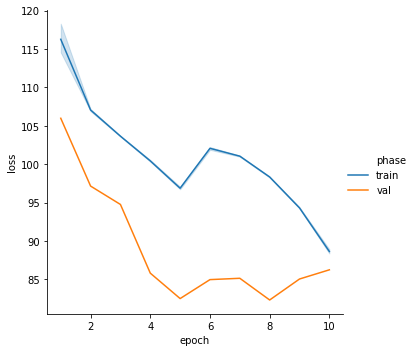

In [40]:
g = sns.relplot(x="epoch", y="loss", hue='phase', kind='line', data=results)